# Vehicle Detection and Tracking
This project implements a pipeline that can be used for detecting and tracking vehicles within a video stream.  Detection and tracking is performed by training a classifier and using that classifier to detect vehicles within recorded samples of dashboard camera footage.  An approach similar to this may prove useful for using video as an input for vehicle collision systems in autonomous vehicles.

# Contents

Below is a list of all the files created and used for this project with a brief description of what is contained in each.

| Filename                     | Description                                                                         |
| --------------------------   |-------------------------------------------------------------------------------------|
| detection_components.py   | Contains a number of classes to perform various parts of the vehicle detection                                         pipelines.                                                                             |
| get_data.py               | A script used to download and extract the images used to train the classifier          |
| Project_Notebook.ipynb    | Jupyter Notebook that walks through the entire pipeline to create a video.  This was                                   used to generate this README.md                                                        |
| pipeline.py               | Defines the main vehicle detection pipeline and the parameters used.                   |
| project_result.mp4        | The result of running the vehicle detection pipeline against project_video.mp4 |
| project_video.mp4         | Video of dashboard footage on which vehicle detection is performed.                    |
| README.md                 | Readme/Write up for this project. |
| test_images/              | Directory containing images used for testing against the vehicle detection pipeline  |
| test_result.mp4           | The result of running the vehicle detection pipeline against test_video.mp4 | 
| test_video.mp4            | Very short video used for testing the vehicle detection pipeline. |
| video_processing.py       | File containing the code for reading in a source video, applying vehicle detection using the trained pipeline, and saving a new video with detected vehicles outlined in a bound box|


# Vehicle Detection Pipeline

At the core of this project is the vehicle detection pipeline. An outline of each stage of the pipeline is described below.

* A collection of images contaiing vehicles and non vehicles is loaded.  These images that will make up the training data used for training a classifier to detect vehicles.

* From each image, features are extracted which will be used for training.  The features extracted consisted of:
  * The pixel values of the image taken in YCrCb color space
  * A histogram of color information in YCrCb color space.
  * HOG features taken across all three YCrCb channels of sample image.
  
* Next, the extracted features along with their labels (vehicles vs nonvehicle) are used to train a Linear SVC classifier.

* Once training is complete, the pipeline is used to detect vehicles in an image/frame of video.  This is done by:
  * Subsampling the image using a sliding window approach with windows of different resolution sizes.
  * Resizing each sub sample and using the classifier to predict whether that sample is a vehcile or not
  * Each sample predicted to be a vehicle is used to generate a heat map.  A threshold is then applied to reduce false positives 
  * A bounding box is determined for each remaing "hot spot" in the heat map and is drawn on the image, representing the area where a vehicle was detected

* Video processing is performed to draw the bounding boxes for the detected vehicles onto the source frame and save as a new video.

Throughout the rest of this document, I will describe the steps of this pipeline in more detail.

# Utility Methods and Imports
Below are the utility methods and imports necessary to generate the images and run the pipeline using a Jupyter notebook.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import random
import time
import math

from scipy.ndimage.measurements import label

from pipeline import VehicleDetectionPipeline
from detection_components import FeatureExtractor
from detection_components import ImageSampler
from video_processing import VideoProcessor

def load_image(image_path, color_conversion=cv2.COLOR_BGR2RGB):
    """Utility method for opening an image using specified color conversion"""
    img = cv2.imread(image_path)
    return cv2.cvtColor(img, color_conversion) 

def show_images(images, titles=[], per_row=None, main_title=None):
    """ Utility method for showing multiple images"""
    
    if per_row is None:
        per_row = math.ceil(math.sqrt(len(images)))

    number_of_titles = len(titles)
    
    figure = plt.figure(1)

    for n, img in enumerate(images):
        ax = figure.add_subplot(np.ceil(len(images) / per_row), per_row, n + 1)

        if n < number_of_titles:
            ax.set_title(titles[n])
        ax.grid(False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis("off")

        plt.imshow(img)
    if main_title is not None:
        plt.suptitle(main_title)

    plt.show()

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Helper method to draw given boxes ontop of an image"""
    # Make a copy of the image
    imcopy = np.copy(img)
    count = 0

    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        count += 1
    # Return the image copy with boxes drawn
    return imcopy


def preview_data(title, data, total_count, image_sample_count=12):
    """Shows details about the vehicle and nonvehicle image collections"""
    count = len(data)
    percentage_of_total = count * 100.0 / total_count
    shape = data[0].shape
    minmax_range = (np.amin(data), np.amax(data))

    sample_images = []
    for i in range(0, image_sample_count):
        sample_images.append(random.choice(data))
        
    show_images(sample_images,  main_title=title)
        
    print('{:s}:'.format(title))
    print('   Count:       {:d} of {:d} ({:3.2f}%)'.format(count, total_count, percentage_of_total))
    print('   Value Range: {} to {}'.format(minmax_range[0], minmax_range[1]))
    print('   Shape:       {} x {}\n\n\n'.format(shape[0], shape[1]))
    
    return count, shape, minmax_range

def add_subplot(title, figure, cols, rows, n):
    ax = figure.add_subplot(cols, rows, n)
    ax.set_title(title)
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

def show_color_hist(img, ch1_name, ch2_name, ch3_name, bin_count):
    feature_extractor = FeatureExtractor()
    ch1, ch2, ch3, bin_centers, hist_features = feature_extractor.color_hist(img, visualize=True, nbins=bin_count)
    
    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, ch1[0])
    plt.xlim(0, 256)
    plt.title(ch1_name)
    plt.subplot(132)
    plt.bar(bin_centers, ch2[0])
    plt.xlim(0, 256)
    plt.title(ch2_name)
    plt.subplot(133)
    plt.bar(bin_centers, ch3[0])
    plt.xlim(0, 256)
    plt.title(ch3_name)
    fig.tight_layout()
    plt.show()



# Loading and Exploring The Data Set

The code used to load vehicle and nonvehicle images into the vehicle detection pipeline is given below.  Examples are shown from each data set.  As you can see, there are 17,760 total images, each with a resolution of 64x64 pixels.  The number of vehicle images is very close to the number of non vehicles which will prevent bias while training.

Finished loading 17760 images in 1.2 seconds.


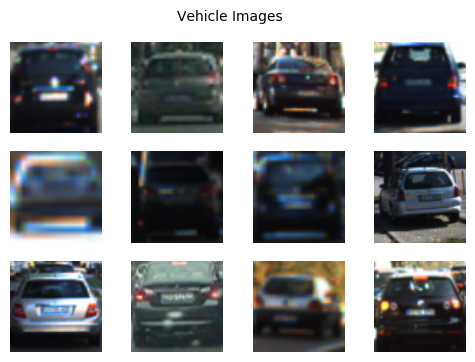

Vehicle Images:
   Count:       8792 of 17760 (49.50%)
   Value Range: 0 to 255
   Shape:       64 x 64





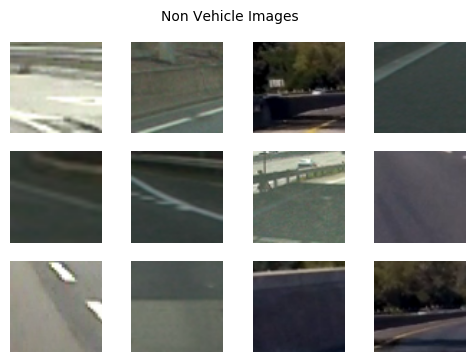

Non Vehicle Images:
   Count:       8968 of 17760 (50.50%)
   Value Range: 0 to 255
   Shape:       64 x 64





In [2]:
# load data into the pipeline
pipeline = VehicleDetectionPipeline(verbose=True)
vehicle_data, non_vehicle_data, image_count = pipeline.load_training_data(vehicle_data_path="vehicles/**/*.png", 
                                                                          nonvehicle_data_path="non-vehicles/**/*.png")
# show details about each data set
result = preview_data("Vehicle Images", vehicle_data, image_count)
result = preview_data("Non Vehicle Images", non_vehicle_data, image_count)

# Feature Extraction

After loading images into the pipeline, the next step is extract useful training features from each image.  A class named **FeatureExtractor** is defined in *detection_components.py* and is used within the pipeline to extract features.

## Feature Types
Looking at the FeatureExtractor class, you will notice there are three feature "types" that are extracted and used in the pipeline.  Details about each are given below.

### Spatial Features
 
The first feature is created by unraveling the pixel values within a chosen colorspace.  Since the ordering of the pixels is maintained, this preserves spatial information about the image.  To determine the best colorspace to use each of the following colorspaces were evaluated:
- RGB
- HSV
- LUV
- HLS
- YUV
- YCrCb

Evaluation included training a classifier where the only feature was the pixel values from that colorspace.  The YCrCb colorspace proved to have the greatest accuracy and was chosen for this reason.  Each channel of the image in this colorspace is shown below.


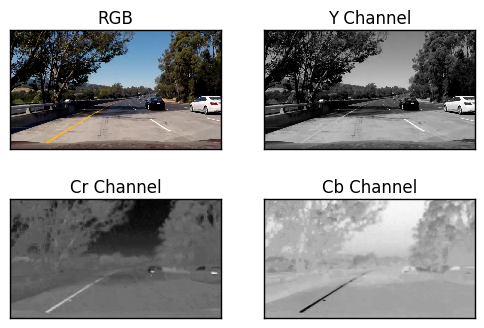

In [3]:
rgb_image = load_image('test_images/test5.jpg')
ycrcb_img = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YCrCb)

figure = plt.figure(1)

# show rgb image
add_subplot("RGB", figure, 2, 2, 1)
plt.imshow(rgb_image)

# show Y Channel
add_subplot("Y Channel", figure, 2, 2, 2)
plt.imshow(ycrcb_img[:,:,0], cmap='gray')

# show Cr Channel
add_subplot("Cr Channel", figure, 2, 2, 3)
plt.imshow(ycrcb_img[:,:,1], cmap='gray')

# show Cb Channel
add_subplot("Cb Channel", figure, 2, 2, 4)
plt.imshow(ycrcb_img[:,:,2], cmap='gray')

plt.show()


### Color Features
The next feature captures only information about color.  Again, the colorspace used is YCrCb.  Colors for each pixel are grouped together into bins across each channel.  This provides a color "signature" for the image independent of spatial constraints.  The number of bins used in the pipeline was 24.  This proved to be enough to maintain an accuracy of over 99% when combined with the other features without drastically impacting performance during training or vehicle detection.  

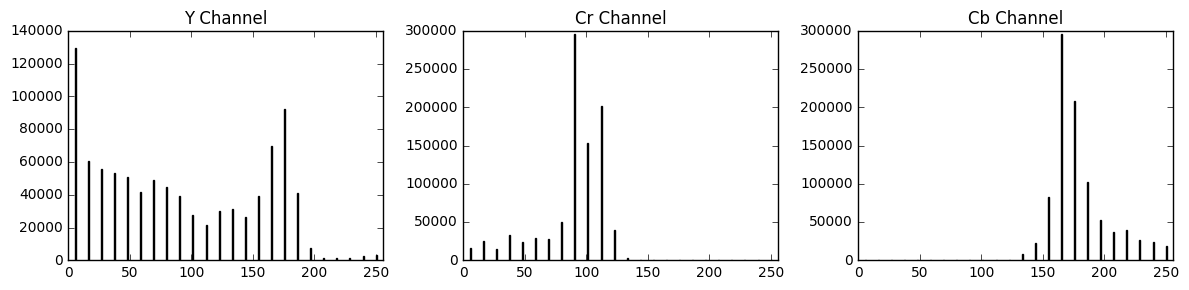

In [4]:
show_color_hist(ycrcb_img, "Y Channel", "Cr Channel", "Cb Channel", bin_count=24)

### Histogram Of Gradients (HOG) Features
The last and perhaps most interesting feature used is a histogram of oriented gradients (HOG). This feature is similar to the way we captured color features, but instead of colors it uses magnitudes of gradients.  To acheive this, a sample image is broken up into cells.  For each cell, a histogram of gradient magnitudes is computed using a specified number of orientations.  When summed up across all cells, this provides a signature for the shape contained within the sample.

The scikit-image package contains a `hog()` method was used to extract this features.  This method takes in a single channel image and parameters for the number of orientations, pixels per cell and cells per block.

### HOG Parameter Selection
Some experimentaion was performed to determine which values should be used for the HOG parameters.  The first experiment was to determine a color space to use.  

The approach to determine the colorspace was to train a classifier using HOG features extracted from a number of different colorspaces.  Fewer colorspaces were experimented with as it turned out to take much longer to train/evaluate HOG features than it did color features.  The colorspaces evaluated were RGB, HSV, HLS, and YCrCb.  Again, YCrCb seemed to perform very well and was chosen.

The next parameter was the number of orientations used in each histogram.  Initially, nine was arbitrarily chosen and allowed me to get over 99% accuracy when training.  However, when I began performing vehicle detection on video inputs, I experimented with setting the orientation to 12.  This seemed to provide better results.

The pixels per cells was initially chosen to be eight.  This value was changed to 6 and then evaluated.  While this did increase the the feature size and the training time, a good amount of accuracy was gained as well so it was left at this value.

HOG features were taken across all channels of the YCrCb colorspace.  Even though this significantly increased the amount of time to extract features, the improvement in accuracy was well worth it.  My average accuracy from the trained classifier using HOG features across all channels compared to any single channel, was almost always 0.5% greater. 

The final parameters used to extract HOG features were:
- Number of orientations: 12
- Cells per block: 2x2
- Pixels per cell: 8x8
- Colorspace: YCrCb
- Channel: ALL

Below are is an illustration of these parameters applied to a sample image.

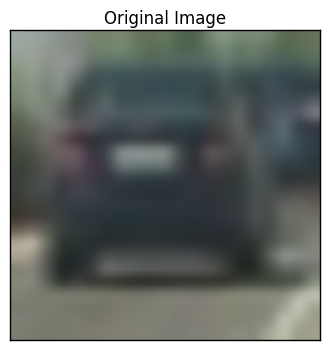

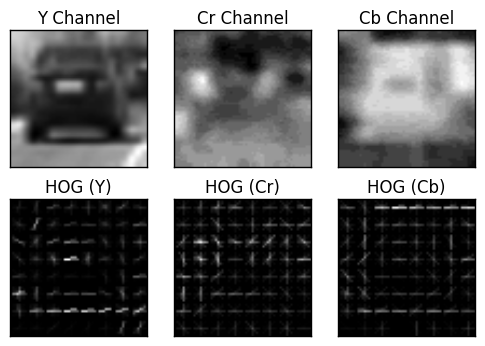

In [5]:
test_image = vehicle_data[0]
ycrcb_img = cv2.cvtColor(test_image, cv2.COLOR_RGB2YCrCb)

feature_extractor = FeatureExtractor()

hog_images = []
for i in range(0,3):
    features, hog_image = feature_extractor.visualize_hog_features(ycrcb_img[:,:,i], 
                                                                   orientations=12, 
                                                                   pixels_per_cell=8, 
                                                                   cells_per_block=2)
    hog_images.append(hog_image)

fig = plt.figure(1)

# show image
add_subplot("Original Image", fig, 1, 1, 1)
plt.imshow(test_image)

fig = plt.figure(2)

# show y Channel
add_subplot("Y Channel", fig, 2, 3, 1)
plt.imshow(ycrcb_img[:,:,0], cmap='gray')

# show cr Channel
add_subplot("Cr Channel", fig, 2, 3, 2)
plt.imshow(ycrcb_img[:,:,1], cmap='gray')

# show cb Channel
add_subplot("Cb Channel", fig, 2, 3, 3)
plt.imshow(ycrcb_img[:,:,2], cmap='gray')

# show Y Ch HOG image
add_subplot("HOG (Y)", fig, 2, 3, 4)
plt.imshow(hog_images[0], cmap='gray')

# show Cr Ch HOG image
add_subplot("HOG (Cr)", fig, 2, 3, 5)
plt.imshow(hog_images[1], cmap='gray')

# show Cb Ch HOG image
add_subplot("HOG (Cb)", fig, 2, 3, 6)
plt.imshow(hog_images[2], cmap='gray')

plt.show()

In the code below we extract the features described above.  Details about the extracted vehicle and non vehicle vectors are shown as well

In [ ]:
# extract features for training
print("Extracting features...")

pipeline.extract_features()
vehicle_features, nonvehicle_features = pipeline.vehicle_features, pipeline.non_vehicle_features

# show shapes of feature vectors
print("Feature Vector Shape:", np.asarray(vehicle_features).shape)
print("Non Vehicle Vector Shape:", np.asarray(nonvehicle_features).shape)


Extracting features...
Finished extracting features in 124 seconds
Feature Vector Shape: (8792, 11736)
Non Vehicle Vector Shape: (8968, 11736)


# Training The Classifier

After all the features are extracted, the next step is to train a classifier.  The `SupportVectorClassifier` class in *detection_components.py* is used by the pipeline to handle training and providing predictions.  This class uses the Linear SVC classifier from sklearn.  After some intial testing, it was clear that the Linear SVC classifier was able to acheive good accuracy in a very small amount of time.  

The `SupportVectorClassifier` normalizes all features using scikit-learn's `StandardScaler` class.  After normalizing and combining the vehicle and non vehicle features the order of feature vector is randomly shuffled.

Using the extracted features described earlier with the Linear SVC classifier consistently produced > 99% accuracy with 25% of the features being witheld from the training set for validation.

The code to train the pipeline with 25% of the training data withheld for validation is shown below.  The resulting accuracy score is shown as well.

In [ ]:
pipeline.train_classifier(test_size=0.25)

# Detecting Vehicles

After a classifier has been trained, the next step is to figure out where vehicles are located in an image.  To acheive this different parts of the image must be sampled and since vehicles near by appear much larger than those in the distance, the sampling size would need to vary as well.

To accomplish this, a sliding windows technique was used.  Samples were only extracted from the lower half of the image, since the upper half never contains vehicles.  

The sliding window technique described here is implemented in the `ImageSampler` class found in *detection_components.py*.

To try to get an estimate of what the size of each sampling windows should be, a large number of frames from the project video were extracted and saved.  Several of these images were viewed in an image editor and the size of a box required to bound the vehicles at various distances from the camera was noted.  

The first implementation used 3 different sizes of windows.  These inital window sizes were 64x64, 128x128, and 256x256.  The 64x64 windows overlapped 50% of their neighboring windows, the 128x128 windows overlapped 65% of their neighbors, and the 256x256 windows overlapped 75% of their neighboring windows.

After testing on a number of project video images, it became clear that this was not going to work well enough.  After testing out a number of various resolution sizes and testing on the project videos, I soon discovered that the sampling did better at detecting parts of the car and more sampling sizes at smaller resolutions provided better results.  The final window sampling used was as follows:

- A 32x32 sample size with 60% overlap
- A 48x48 sample size with 80% overlap
- A 64x64 sample size with 80% overlap
- A 128x128 sample size with 80% overlap

Below the 128x128 windows samples are shown overlayed on top of a test image.


In [ ]:
img = load_image('test_images/test1.jpg')
sampler = ImageSampler(img.shape)

windows = sampler.slide_window(img.shape, x_start_stop=[200, None], y_start_stop=[400, 700],
                                     xy_window=(128, 128), xy_overlap=(0.8, 0.8))

show_images([draw_boxes(img, windows[0::25])], titles=["128 x 128 Windows (1 / 25 shown)"])
show_images([draw_boxes(img, windows)], titles=["128x128 Windows (All)"])

# Multiple Detections and False Positives

When sampling many windows from an image and running each sample through a classifier, it is likely that several of the sample windows will be predicted as a car for a single car in the image.  To resolve this issue the `HeatMapFilter` class found in *detection_components.py* was created.  

The `HeatMapFilter` class implements a "heat map" approach.  An empty array is created that is the same size as the source image.  For each window that tested positive for a vehicle, the window area of the array is incremented by one.  This produces a heat map where the higher concentration of detected images is "hotter".  The heat map is then used with Scipy's `label()` method to return bounding boxes where car instances are expected.

Occasionaly, images that were not vehicles were predicted to be vehicles.  To prevent reduce these false positives, after a heat map has been generated, a "hotness" threshold was established.  Areas where less samples were detected would then be discarded.  A threshold of 2 samples seemed to perform well at reducing false positives while continuing to accurately detect vehiceles.


Below is the code that was used to evaluate how well the sampling, heat mapping, and threshold filtering was performing and some results of the current implementation.  The images below show the final bounding box for the vehicle on the left and a heat map created from all the positive samples received using the sliding window approach.

In [ ]:
image_numbers = [1920,720, 690, 900]
for img_number in image_numbers:
    img = load_image('project_video_images/frame{:d}.jpg'.format(img_number))

    labeled_boxes, heatmap = pipeline.detect_vehicles(img, threshold=2, return_heatmap=True)
    labled_img = draw_boxes(img, labeled_boxes)
    
    show_images((labled_img,heatmap), per_row=2)


# Results

The video generated after being processed through the pipeline can be found below.

[![Project Video](teaser.png)](project_result.mp4)

# Reflections
The most challenging part of this project was fine tuning the parameters used in the pipeline.  While feature extraction and training could be completed much quicker when compared to other machine learning approaches such as neural networks, processing video turned out to be a very slow process.  The resulting video took nearly two hours to process.  The reason for this was likely due to the large number of windows sampled from each frame.  Extracting HOG features from each subsample is likely the step that required the most time and processing power.  In the future, this project could be updated so that HOG features are extracted from the entire image once for each image channel and then samples are taken from there.

While the video produced does a decent job of identifying vehicles, further work can be done to improve the results.  You may have noticed a couple places where false positives were shown.  Improving upon the training set and further refining the threshold on the heatmap may improve these results.  

Finally, one last idea I had to improve results was to use a decaying heatmap.  Instead of clearing the heat map each time a new frame is processed, the values in the heat map would be multiplied by some decay factor, say 0.5.  This would cause places in the heat map where a car was dected with high confidence to maintain nonzero values.  This makes sense when processing video since the car is likely to be close to the same spot from frame to frame. 
